# Obteniendo parámetos para la simulación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Cargando Datos

In [2]:
df_tiempos = pd.read_excel("Tiempos Pacientes Limpios.xlsx")
df_turnos = pd.read_excel("Turnos Pacientes Limpios.xlsx")

In [3]:
medias_modalidades = pd.read_excel("medias_por_estudio_sucursal.xlsx")
medias_modalidades_dict = medias_modalidades.set_index(['Sucursal', 'EstudioModalidad']).to_dict('index')

medias_turnos = pd.read_excel("medias_por_sucursal.xlsx")
medias_turnos_dict = medias_turnos.set_index(['Sucursal']).to_dict('index')

## Parámetros necesarios

Cada uno de los siguientes parámetros se deben de obtener para cada sucursal. Todos los parámetros se guardarán en un archivo json

- Distribución de llegada por dia a lo largo del tiempo en cada dia de la semana
- Distribución de la cantidad de estudios por persona
- Cantidad media de cada tipo de estudios por sucursal en un dia


### Distribución de llegada

In [4]:
# 1. Leer archivo CSV
df = df_turnos.copy()

# 2. Preprocesamiento de columnas necesarias
df['TurnoHoraFin'] = pd.to_datetime(df['TurnoHoraFin'], format="%H:%M:%S", errors='coerce')
df['HoraRecepcion'] = df['TurnoHoraFin'] + pd.to_timedelta(df['TAPRecepcionMinutos'], unit='m')
df = df.dropna(subset=['HoraRecepcion'])

# 3. Generar identificador de fecha e intervalo de 10 minutos
df['Fecha'] = pd.to_datetime(df['FechaID'], format="%Y%m%d", errors='coerce')
df['Intervalo10m'] = df['HoraRecepcion'].dt.floor('10min')

# 4. Agrupar por día, sucursal e intervalo y contar llegadas
daily_counts = df.groupby(['Sucursal', 'Fecha', 'Intervalo10m']).size().rename('Cantidad').reset_index()

# 5. Calcular promedio diario por intervalo y sucursal
average_distribution = (
    daily_counts
    .groupby(['Sucursal', 'Intervalo10m'])['Cantidad']
    .mean()
    .round(2)
    .reset_index()
)

# 6. Extraer solo la hora y redondear cantidad al entero más cercano
average_distribution['Hora'] = average_distribution['Intervalo10m'].dt.time
average_distribution['Cantidad'] = average_distribution['Cantidad'].round().astype(int)

# 7. Organizar columnas finales
distribucion_llegada = average_distribution[['Sucursal', 'Hora', 'Cantidad']]

In [5]:
# Mostrar resultado
distribucion_llegada

,Sucursal,Hora,Cantidad
0,COYOACAN,05:50:00,4
1,COYOACAN,06:00:00,9
2,COYOACAN,06:10:00,12
3,COYOACAN,06:20:00,14
4,COYOACAN,06:30:00,15
...,...,...,...
547,CULIACAN UNIVERSITARIOS,17:20:00,3
548,CULIACAN UNIVERSITARIOS,17:30:00,2
549,CULIACAN UNIVERSITARIOS,17:40:00,2
550,CULIACAN UNIVERSITARIOS,17:50:00,2


In [71]:
distribucion_llegada.to_csv("parametros_simulación/distribucion_llegada.csv", index=False)

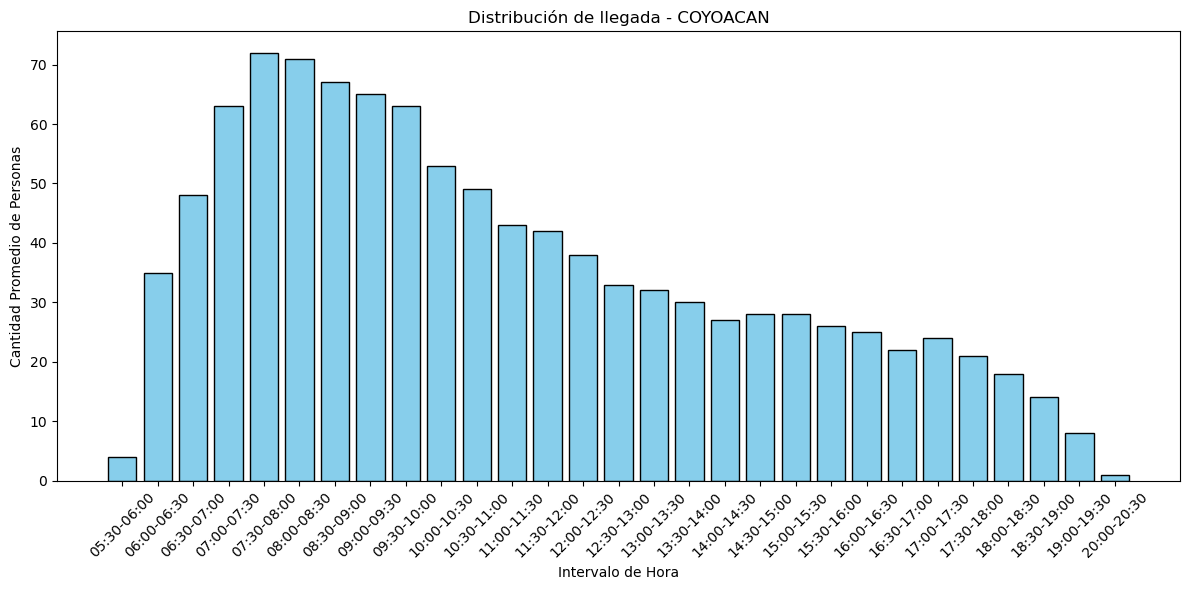

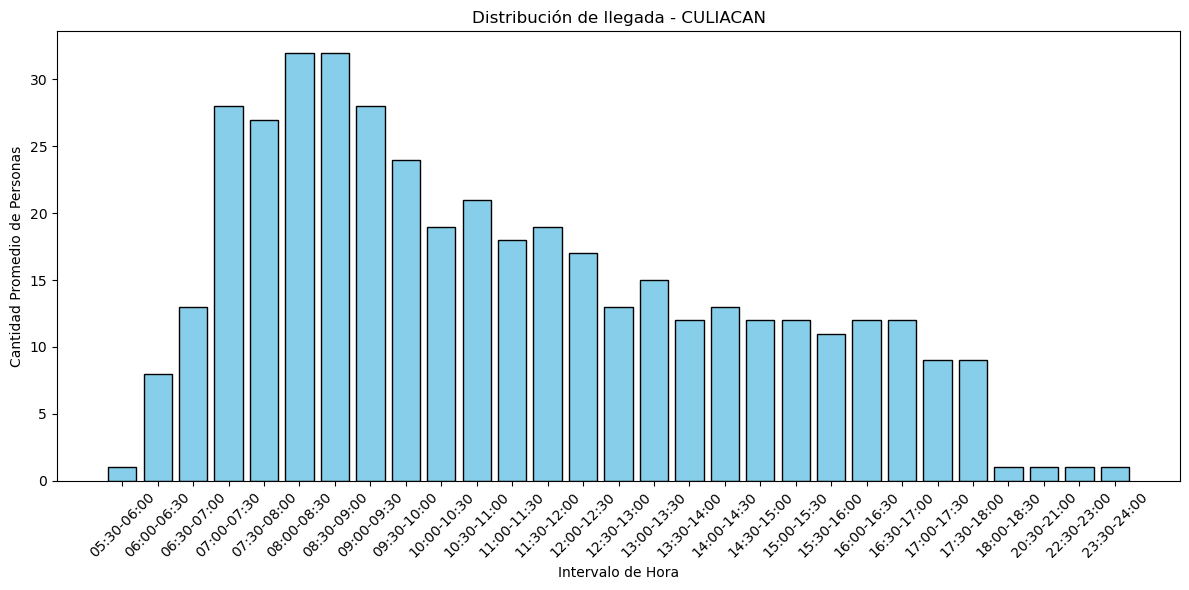

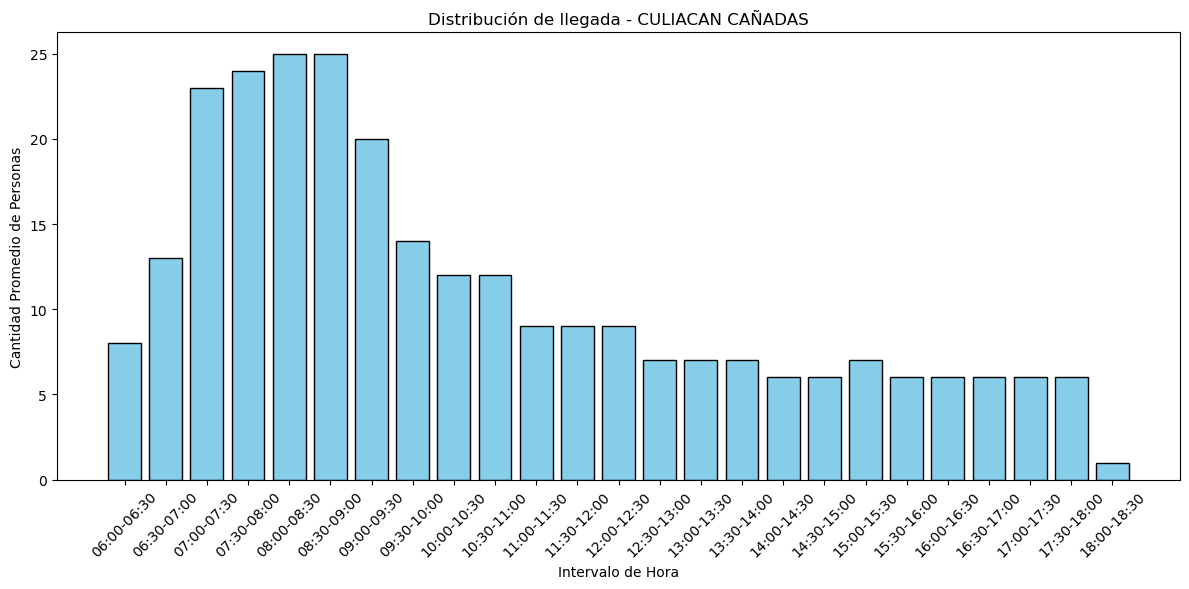

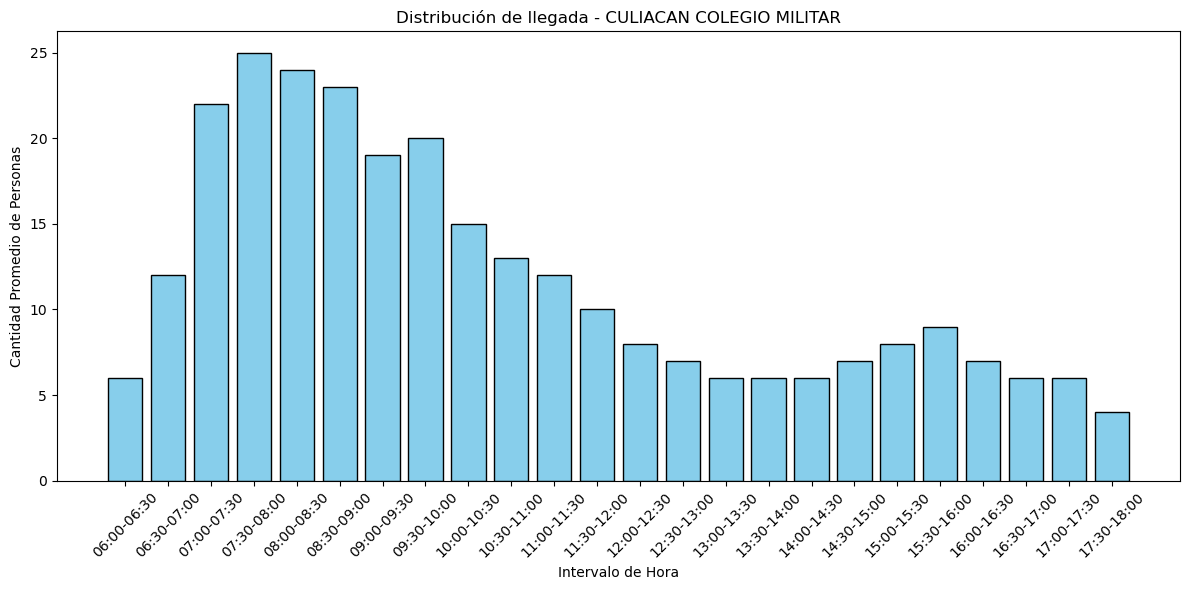

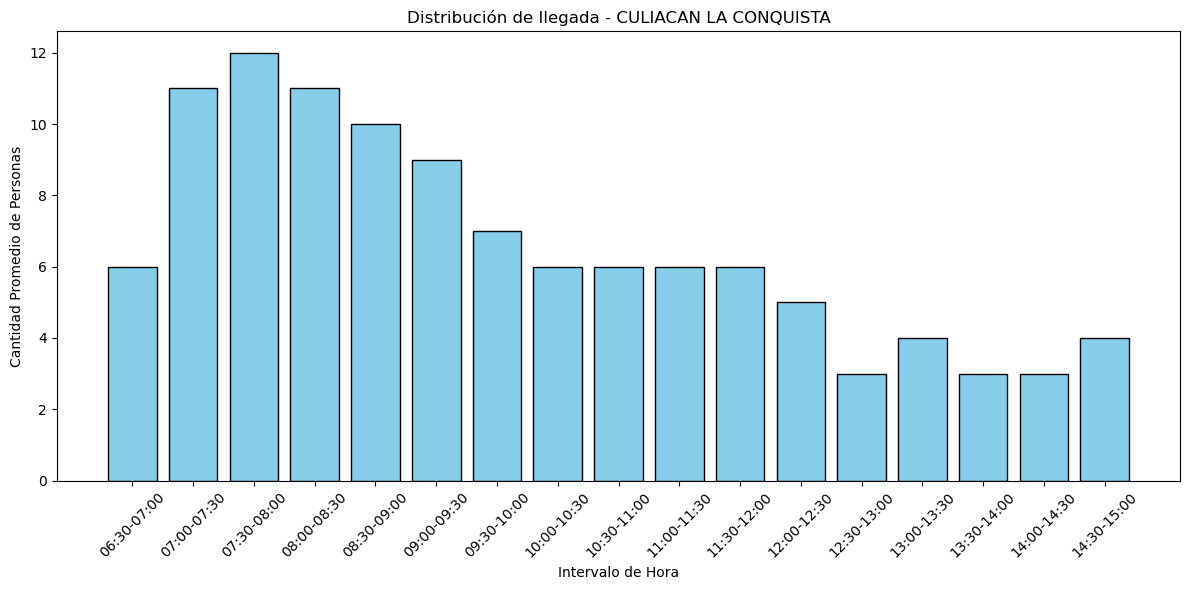

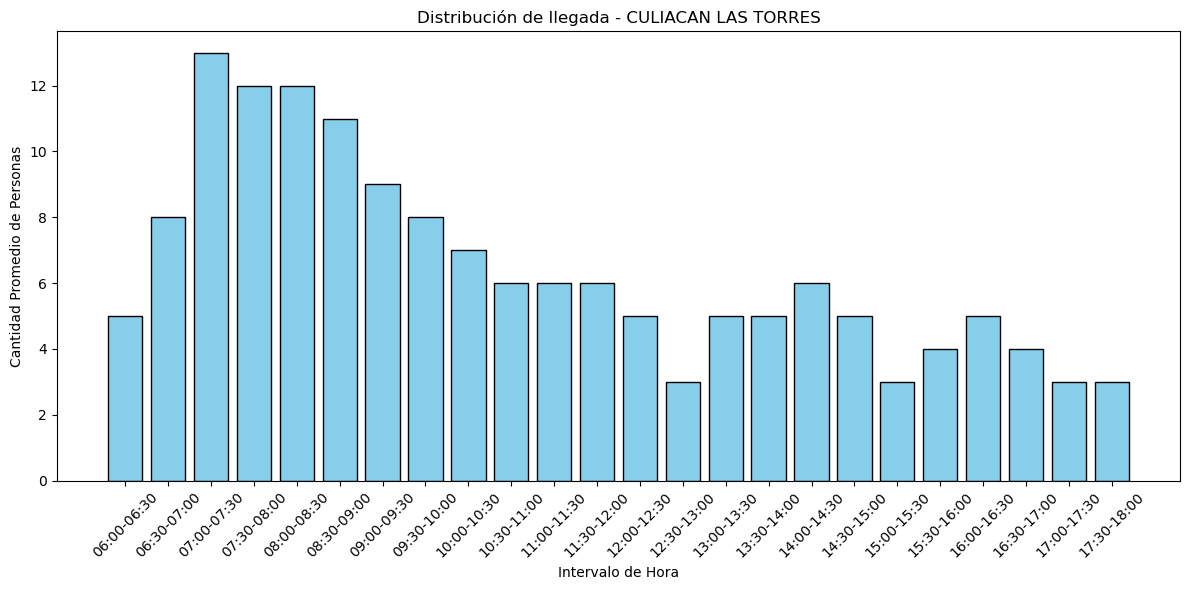

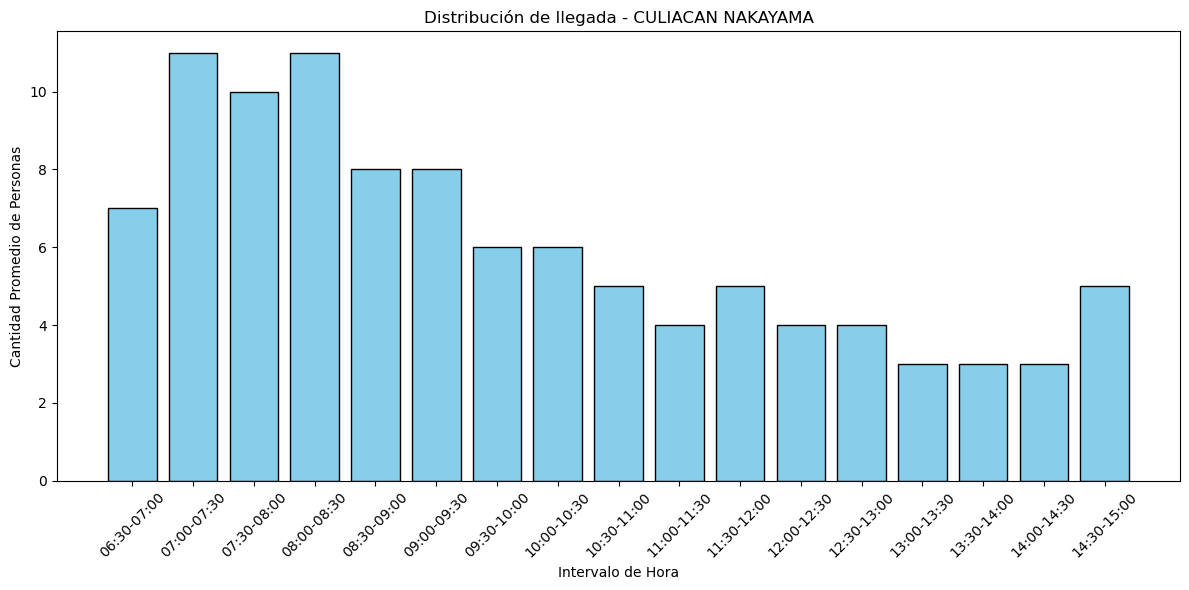

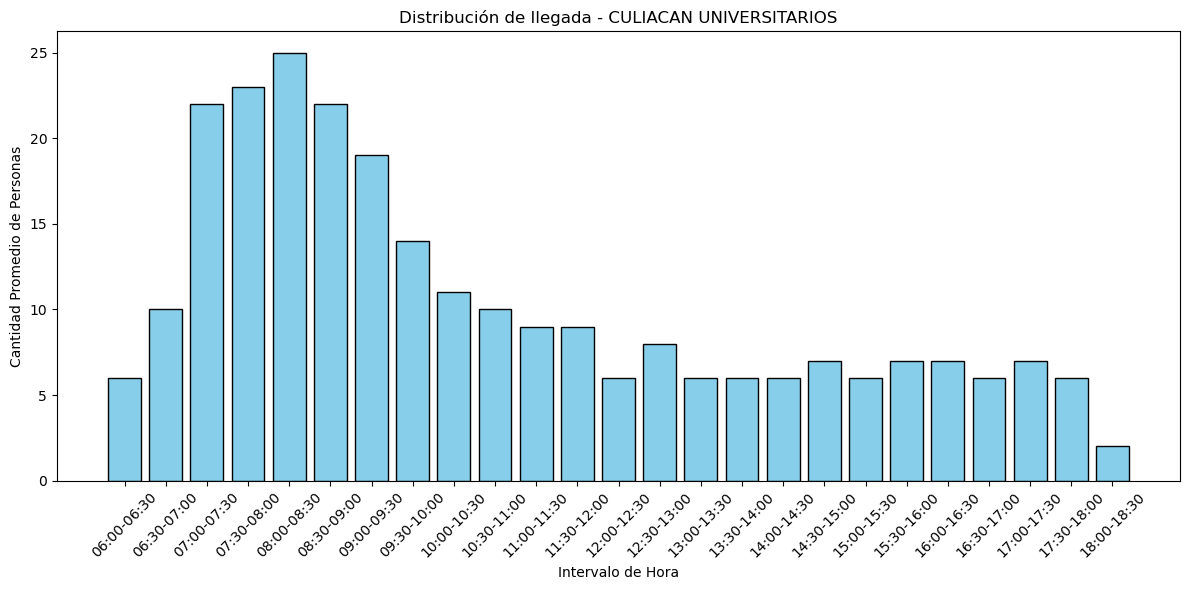

In [9]:
sucursales = distribucion_llegada['Sucursal'].unique()

for suc in sucursales:
    plt.figure(figsize=(12, 6))
    datos = distribucion_llegada[distribucion_llegada['Sucursal'] == suc].copy()
    
    # Convertir la hora a minutos desde medianoche para facilitar el agrupamiento
    datos['minutos'] = datos['Hora'].apply(lambda x: x.hour * 60 + x.minute)
    
    # Crear intervalos de 30 minutos
    datos['Intervalo'] = datos['minutos'].apply(
        lambda x: f"{(x//30*30)//60:02d}:{(x//30*30)%60:02d}-{((x//30*30+30)//60):02d}:{((x//30*30+30)%60):02d}"
    )
    
    # Agrupar por intervalo y sumar las cantidades
    datos_agrupados = datos.groupby('Intervalo')['Cantidad'].sum().reset_index()
    
    plt.bar(datos_agrupados['Intervalo'], datos_agrupados['Cantidad'], color='skyblue', edgecolor='black')
    plt.title(f'Distribución de llegada - {suc}')
    plt.xlabel('Intervalo de Hora')
    plt.ylabel('Cantidad Promedio de Personas')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Distribución de la cantidad de estudios por persona en cada sucursal

In [19]:

# Calcular la cantidad de estudios por paciente y sucursal
estudios_por_paciente = df_tiempos.groupby(['Sucursal', 'PacienteID']).size().reset_index(name='CantidadEstudios')

# Calcular estadísticas por sucursal
estadisticas_por_sucursal = estudios_por_paciente.groupby('Sucursal').agg({
    'CantidadEstudios': ['count', 'mean', 'median', 'min', 'max']
}).round(2).reset_index()

# Renombrar las columnas para mayor claridad (incluyendo 'Sucursal')
estadisticas_por_sucursal.columns = [
    'Sucursal', 'TotalPacientes', 'PromedioEstudios', 'MedianaEstudios', 'MinEstudios', 'MaxEstudios'
]

# Redondear la columna PromedioEstudios a un entero
estadisticas_por_sucursal['PromedioEstudios'] = estadisticas_por_sucursal['PromedioEstudios'].round(0).astype(int)

# Mostrar resultados
print("Estadísticas de estudios por paciente por sucursal:")
display(estadisticas_por_sucursal)

Estadísticas de estudios por paciente por sucursal:


,Sucursal,TotalPacientes,PromedioEstudios,MedianaEstudios,MinEstudios,MaxEstudios
0,COYOACAN,23136,2,1.0,1,10
1,CULIACAN,9277,2,1.0,1,9
2,CULIACAN CAÑADAS,6374,2,1.0,1,8
3,CULIACAN COLEGIO MILITAR,5797,1,1.0,1,8
4,CULIACAN LA CONQUISTA,1985,1,1.0,1,5
5,CULIACAN LAS TORRES,3475,2,1.0,1,8
6,CULIACAN NAKAYAMA,1782,1,1.0,1,6
7,CULIACAN UNIVERSITARIOS,5505,2,1.0,1,10


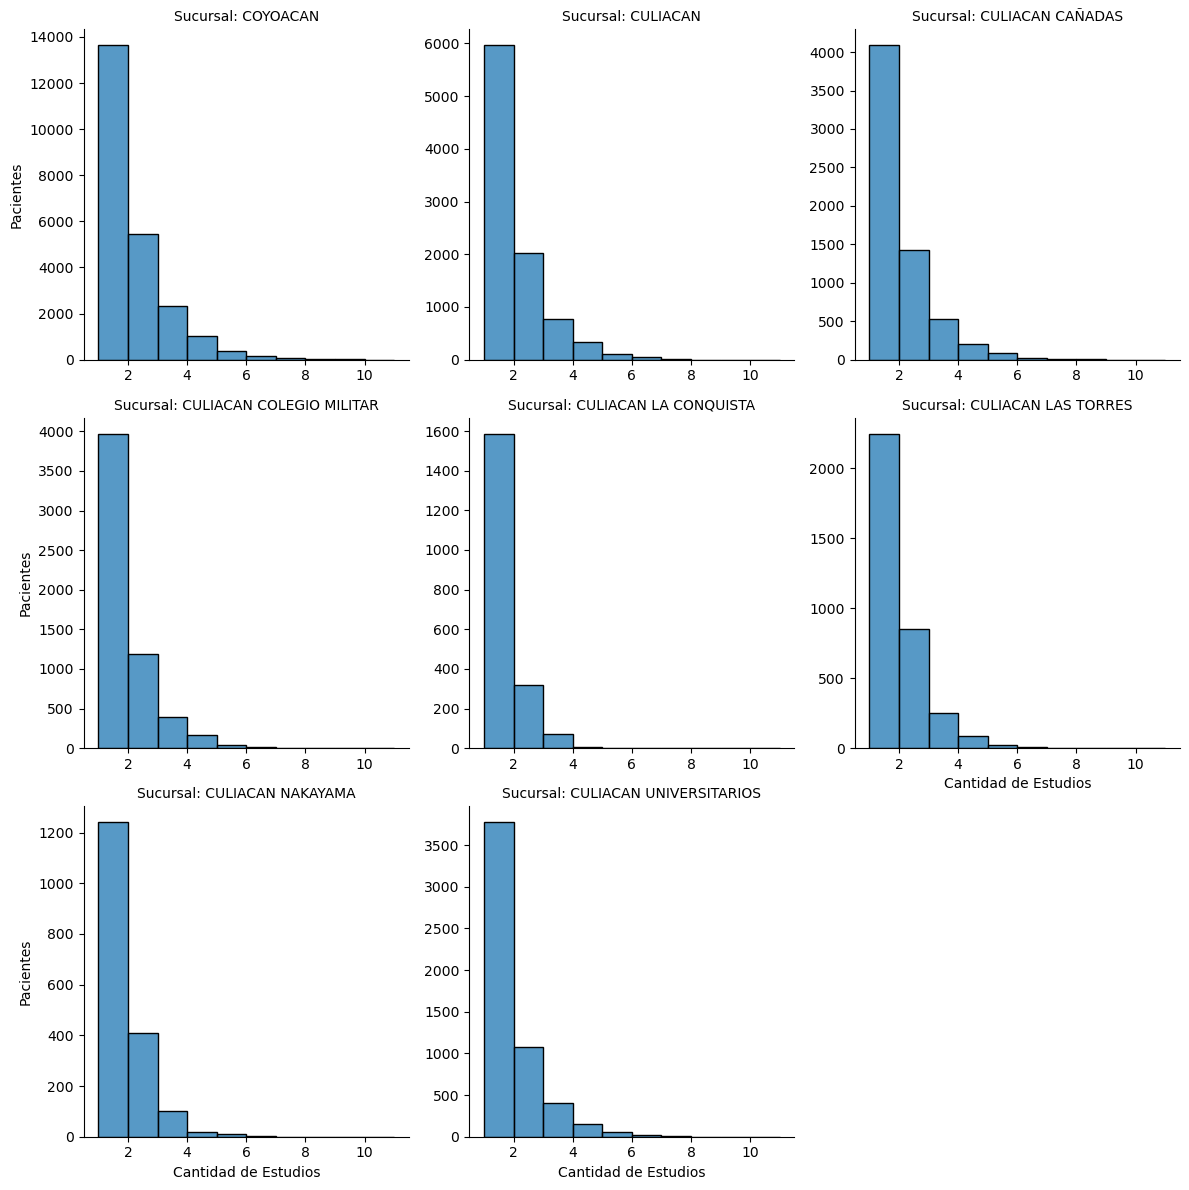

In [20]:
g = sns.FacetGrid(estudios_por_paciente, col="Sucursal", col_wrap=3, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.histplot, x="CantidadEstudios", bins=range(1, estudios_por_paciente['CantidadEstudios'].max()+2), kde=False)
g.set_axis_labels("Cantidad de Estudios", "Pacientes")
g.set_titles("Sucursal: {col_name}")
plt.tight_layout()
plt.show()

In [21]:
# Tabla de frecuencias: para cada sucursal, cuántos pacientes tienen 1, 2, 3... estudios
distribucion = estudios_por_paciente.groupby(['Sucursal', 'CantidadEstudios']).size().reset_index(name='NumPacientes')
distribucion

,Sucursal,CantidadEstudios,NumPacientes
0,COYOACAN,1,13646
1,COYOACAN,2,5457
2,COYOACAN,3,2331
3,COYOACAN,4,1024
4,COYOACAN,5,395
...,...,...,...
58,CULIACAN UNIVERSITARIOS,5,62
59,CULIACAN UNIVERSITARIOS,6,22
60,CULIACAN UNIVERSITARIOS,7,6
61,CULIACAN UNIVERSITARIOS,8,1


In [22]:
distribucion.to_csv("distribucion_cantidad_estudios.csv", index = False)

### Probabilidad de que un paciente se realice cada estudio

In [76]:
# Agrupa por sucursal, modalidad y fecha, y cuenta los estudios por día
estudios_por_dia = df_tiempos.groupby(['Sucursal', 'EstudioModalidad', 'TEPFechaEspera']).size().reset_index(name='EstudiosPorDia')

In [77]:
promedio_estudios = estudios_por_dia.groupby(['Sucursal', 'EstudioModalidad'])['EstudiosPorDia'].mean().reset_index()

In [78]:
promedio_estudios[promedio_estudios['Sucursal'] == 'COYOACAN'].sort_values(by=['EstudiosPorDia'], ascending=True)

,Sucursal,EstudioModalidad,EstudiosPorDia
9,COYOACAN,TOMOGRAFIA,29.354839
8,COYOACAN,RESONANCIA MAGNETICA,30.677419
4,COYOACAN,NUTRICION,40.576923
6,COYOACAN,PAPANICOLAOU,40.806452
3,COYOACAN,MASTOGRAFIA,45.741935
1,COYOACAN,ELECTROCARDIOGRAMA,88.032258
0,COYOACAN,DENSITOMETRIA,95.838710
5,COYOACAN,OPTOMETRIA,162.967742
10,COYOACAN,ULTRASONIDO,189.258065
7,COYOACAN,RAYOS X,190.903226


In [79]:
# Calcular el total de estudios por sucursal
total_por_sucursal = promedio_estudios.groupby('Sucursal')['EstudiosPorDia'].sum().reset_index(name='TotalEstudiosSucursal')

# Unir el total al DataFrame de promedios
promedio_estudios = promedio_estudios.merge(total_por_sucursal, on='Sucursal')

# Calcular la probabilidad por sucursal
promedio_estudios['Probabilidad'] = promedio_estudios['EstudiosPorDia'] / promedio_estudios['TotalEstudiosSucursal']

In [80]:
# Mostrar el resultado
promedio_estudios = promedio_estudios[['Sucursal', 'EstudioModalidad', 'Probabilidad']].sort_values(by=["Sucursal", "Probabilidad"], ascending=False)

In [81]:
promedio_estudios

,Sucursal,EstudioModalidad,Probabilidad
60,CULIACAN UNIVERSITARIOS,LABORATORIO,0.404981
65,CULIACAN UNIVERSITARIOS,RAYOS X,0.153375
63,CULIACAN UNIVERSITARIOS,OPTOMETRIA,0.144820
66,CULIACAN UNIVERSITARIOS,ULTRASONIDO,0.126679
58,CULIACAN UNIVERSITARIOS,DENSITOMETRIA,0.054733
...,...,...,...
3,COYOACAN,MASTOGRAFIA,0.031705
6,COYOACAN,PAPANICOLAOU,0.028284
4,COYOACAN,NUTRICION,0.028125
8,COYOACAN,RESONANCIA MAGNETICA,0.021263


In [82]:
promedio_estudios.to_csv("parametros_simulación/promedio_estudios.csv", index=False)